## s&p500 하락/상승 예측

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

%config Completer.use_jedi = False

In [2]:
import pandas as pd

interest_rates_df = pd.read_csv('./interest_rates.csv')
sandp500_df = pd.read_csv('./s&p500.csv')
bbc_news_df = pd.read_csv('./bbc_news.csv')

In [3]:
interest_rates_df.tail()
sandp500_df.head()
bbc_news_df.head()

,year,month,interest_rate,unemployment_rate,index_price
1195,2019,12,3.44,2.83,767.901200
1196,2020,12,2.98,3.62,541.022220
1197,2021,12,3.55,3.49,731.564473
1198,2022,12,3.22,5.31,435.166468
1199,2023,12,4.36,5.10,810.947961


,year_month,open,high,low,close,volume,change
0,Dec-23,"4,674.25","4,892.25","4,652.00","4,871.50",22.69K,6.44%
1,Nov-23,"4,205.00","4,597.00","4,191.25","4,576.75",31.57M,8.65%
2,Oct-23,"4,349.00","4,430.50","4,122.25","4,212.25",43.89M,-2.62%
3,Sep-23,"4,516.75","4,547.75","4,277.00","4,325.50",28.95M,-4.22%
4,Aug-23,"4,617.75","4,621.75","4,350.00","4,516.00",36.24M,-2.13%


,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


#### 구글 주식에 영향을 미치는 요인 추청
 - 금리
 - 실업률
 - 뉴스량
 - 거래량
 - 시가, 종가, 가격변화

#### s&p500의 하락/상승을 예측하기 위해
 1) 뉴스기사량 월별로 정리
 2) 월별 시가, 종가, 거래량, 변화 등등 수치값 전처리
 3) 데이터프레임 한개로 합치기
 4) 전월대비 상승 하락 label값 지정

In [4]:
bbc_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42115 entries, 0 to 42114
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        42115 non-null  object
 1   pubDate      42115 non-null  object
 2   guid         42115 non-null  object
 3   link         42115 non-null  object
 4   description  42115 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


In [5]:
# 데이터 전처리
# 뉴스기사량 월별 정리
bbc_news_df_drop = bbc_news_df.copy()
bbc_news_df_drop['pubDate'] = pd.to_datetime(bbc_news_df_drop['pubDate'], format='%a, %d %b %Y %H:%M:%S %Z') # 데이터 타입을 datetime으로 변환
bbc_news_df_drop['year_month'] = bbc_news_df_drop['pubDate'].dt.to_period('M') # 년도와 월가지만 추출

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15408\1726833146.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  bbc_news_df_drop['year_month'] = bbc_news_df_drop['pubDate'].dt.to_period('M') # 년도와 월가지만 추출


In [6]:
# 뉴스 데이터는 2022-03 부터 2024-11 까지만 쓸모있어보임

In [7]:
#  월별 시가, 종가, 거래량, 변화 등등 수치값 전처리
sandp500_df_drop = sandp500_df.copy()
# 날짜 전처리
sandp500_df_drop['year_month'] = pd.to_datetime(sandp500_df_drop['year_month'], format='%b-%y') # datetime 으로 형식 변환
sandp500_df_drop['year_month'] = sandp500_df_drop['year_month'].dt.to_period('M')  # 연도-월로 변환

# Volume 값 수치화
sandp500_df_drop['volume'] = sandp500_df_drop['volume'].map(lambda x: float(x.replace('K', '')) * 1000 if 'K' in x
                                                            else (float(x.replace('M', '')) * 1000000 if 'M' in x else float(x)))

# %기호 제거
sandp500_df_drop['change'] = sandp500_df_drop['change'].replace('%', '', regex=True).astype(float)
sandp500_df_drop

# 인덱스 설정
sandp500_df_drop.set_index('year_month', inplace=True) # 날짜로 인덱스 지정
sandp500_df_drop.sort_index(inplace=True)

,year_month,open,high,low,close,volume,change
0,2023-12,"4,674.25","4,892.25","4,652.00","4,871.50",22690.0,6.44
1,2023-11,"4,205.00","4,597.00","4,191.25","4,576.75",31570000.0,8.65
2,2023-10,"4,349.00","4,430.50","4,122.25","4,212.25",43890000.0,-2.62
3,2023-09,"4,516.75","4,547.75","4,277.00","4,325.50",28950000.0,-4.22
4,2023-08,"4,617.75","4,621.75","4,350.00","4,516.00",36240000.0,-2.13
5,2023-07,"4,485.50","4,634.50","4,411.25","4,614.50",27750000.0,2.81
6,2023-06,"4,188.50","4,498.00","4,178.00","4,488.25",31240000.0,7.11
7,2023-05,"4,190.00","4,243.25","4,062.25","4,190.50",35560000.0,0.05
8,2023-04,"4,127.00","4,198.25","4,068.75","4,188.50",29180000.0,1.23
9,2023-03,"3,968.50","4,142.50","3,808.75","4,137.75",38850000.0,4.08


In [8]:
sandp500_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 22 entries, 2022-03 to 2023-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    22 non-null     object 
 1   high    22 non-null     object 
 2   low     22 non-null     object 
 3   close   22 non-null     object 
 4   volume  22 non-null     float64
 5   change  22 non-null     float64
dtypes: float64(2), object(4)
memory usage: 1.2+ KB


In [9]:
 #하락/상승 여부 columns 추가
sandp500_df_drop['inc_dec'] = sandp500_df_drop['change'].map(lambda x: 1 if x>0
                                                             else 0)
sandp500_df_drop # 1이 상승, 0이 하락

,open,high,low,close,volume,change,inc_dec
year_month,,,,,,,
2022-03,"4,367.50","4,631.00","4,138.00","4,530.75",31760000.0,3.73,1
2022-04,"4,541.00","4,588.75","4,118.75","4,127.50",32230000.0,-8.90,0
2022-05,"4,144.00","4,303.00","3,807.50","4,131.25",42400000.0,0.09,1
2022-06,"4,138.50","4,189.00","3,639.00","3,789.50",32600000.0,-8.27,0
2022-07,"3,782.00","4,144.00","3,723.75","4,133.50",34090000.0,9.08,1
2022-08,"4,137.50","4,327.50","3,953.00","3,956.50",38470000.0,-4.28,0
2022-09,"3,958.00","4,158.00","3,595.25","3,601.50",44230000.0,-8.97,0
2022-10,"3,593.25","3,924.25","3,502.00","3,883.00",48070000.0,7.82,1
2022-11,"3,884.00","4,093.50","3,704.25","4,081.25",36190000.0,5.11,1


In [10]:
# interest_rate전처리 
interest_rates_df_drop = interest_rates_df.copy()
interest_rates_df_drop['year_month'] = interest_rates_df_drop['year'].astype(str) + '-' + interest_rates_df_drop['month'].astype(str)
interest_rates_df_drop = interest_rates_df_drop.drop(columns=['year', 'month']) # columns 삭제

interest_rates_df_drop['year_month'] = pd.to_datetime(interest_rates_df_drop['year_month'], format='%Y-%m') # datetime 으로 형식 변환
interest_rates_df_drop['year_month'] = interest_rates_df_drop['year_month'].dt.to_period('M')  # 연도-월로 변환
interest_rates_df_drop = interest_rates_df_drop[interest_rates_df_drop['year_month'] > '2022-02'] # 2022-03 금리부터 추출
interest_rates_df_drop.set_index('year_month', inplace=True) # 날짜로 인덱스 지정
interest_rates_df_drop.sort_index(inplace=True)
# interest_rate = 금리
# unemployment_rate = 실업율
# index_price = 합성 주식 시장 지수
# 2022-03 부터 2023-12 까지 데이터

In [11]:
# 다른 데이터에 맞춰 뉴스 데이터 index 통일
bbc_news_df_drop = bbc_news_df_drop[(bbc_news_df_drop['year_month']>'2022-02') & (bbc_news_df_drop['year_month']<='2023-12')] # 2022-03 뉴스 부터 추출

# pivot table 생성
news_amount = bbc_news_df_drop.pivot_table(index='year_month', values='title', aggfunc='count')
news_amount = news_amount.rename(columns={'title': 'news_amount'})

In [12]:
# 데이터 병합
result_df = pd.concat([sandp500_df_drop, interest_rates_df_drop, news_amount], axis=1)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 22 entries, 2022-03 to 2023-12
Freq: M
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               22 non-null     object 
 1   high               22 non-null     object 
 2   low                22 non-null     object 
 3   close              22 non-null     object 
 4   volume             22 non-null     float64
 5   change             22 non-null     float64
 6   inc_dec            22 non-null     int64  
 7   interest_rate      22 non-null     float64
 8   unemployment_rate  22 non-null     float64
 9   index_price        22 non-null     float64
 10  news_amount        22 non-null     int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 2.1+ KB


In [13]:
result_df.to_csv('./sandp_final.csv', index=0, encoding='utf-8-sig')
result_df = pd.read_csv('./sandp_final.csv')

### 각 column 분석
 - open: 시가
 - high: 고가
 - low: 저가
 - close: 종가
 - volume: 거래량
 - change: 변동값
 - inc_dec: 상승/하락 여부
 - interest_rate: 금리
 - unemployment_rate: 실업률
 - index_price: 합성 주식 시장 지수
 - news_amount: bbc기사량

In [14]:
# 시각화를 위한 float 형태 변환
result_df['open'] = result_df['open'].replace(',', '', regex=True).astype(float)
result_df['high'] = result_df['high'].replace(',', '', regex=True).astype(float)
result_df['low'] = result_df['low'].replace(',', '', regex=True).astype(float)
result_df['close'] = result_df['close'].replace(',', '', regex=True).astype(float)

<Figure size 1600x800 with 0 Axes>

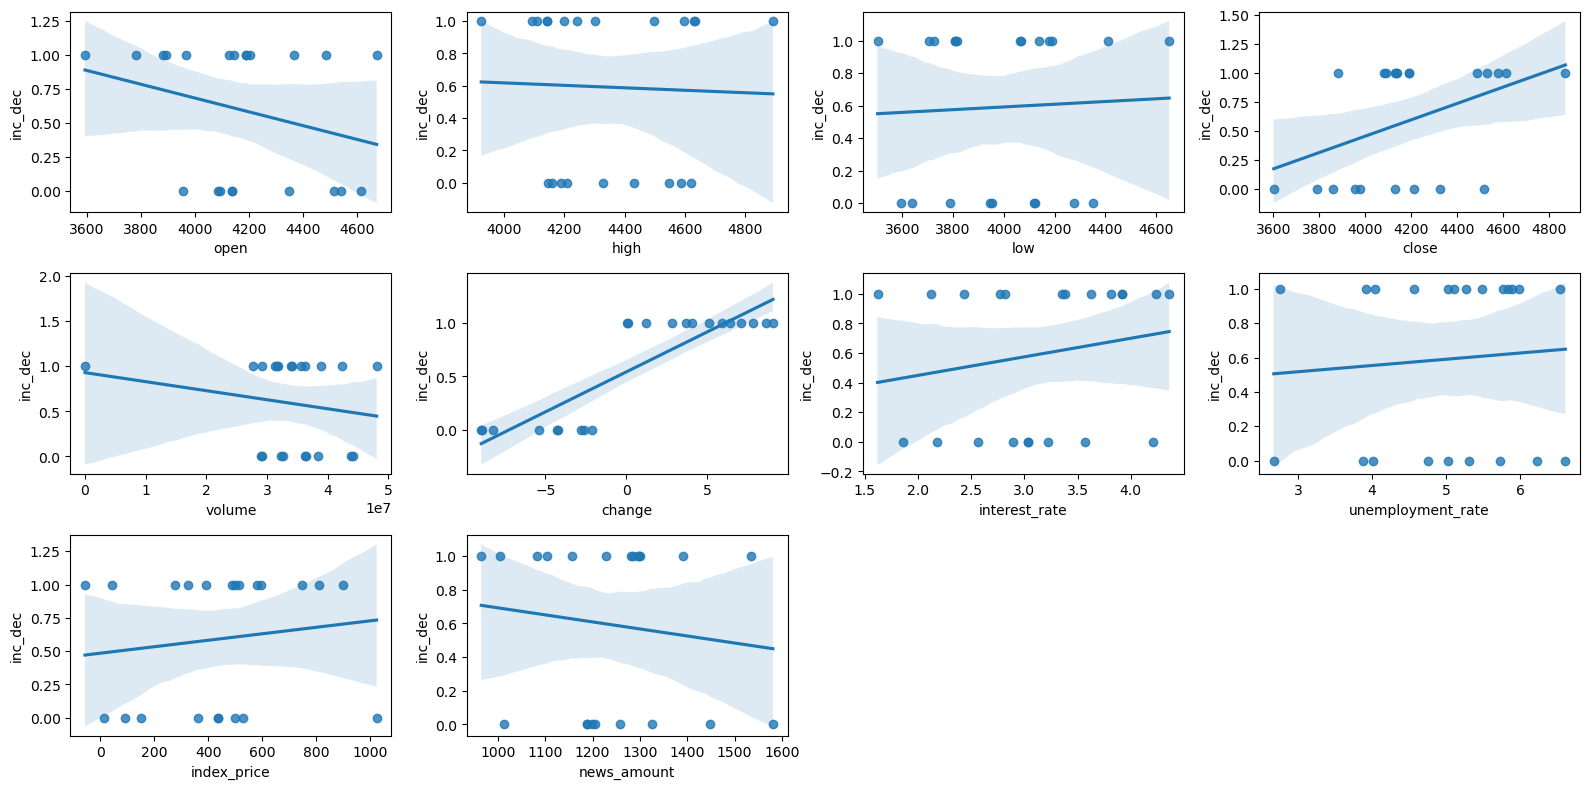

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns

# 상관관계 분석
# 영향을 미치는 피처 확인
features = ['open', 'high', 'low', 'close', 'volume', 'change', 'interest_rate',
            'unemployment_rate', 'index_price', 'news_amount']

plt.figure(figsize=(16, 8))
for i, feature in enumerate(features):
    _=plt.subplot(3, 4, i+1)
    _=sns.regplot(x=feature, y='inc_dec', data=result_df)

plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

<Axes: >

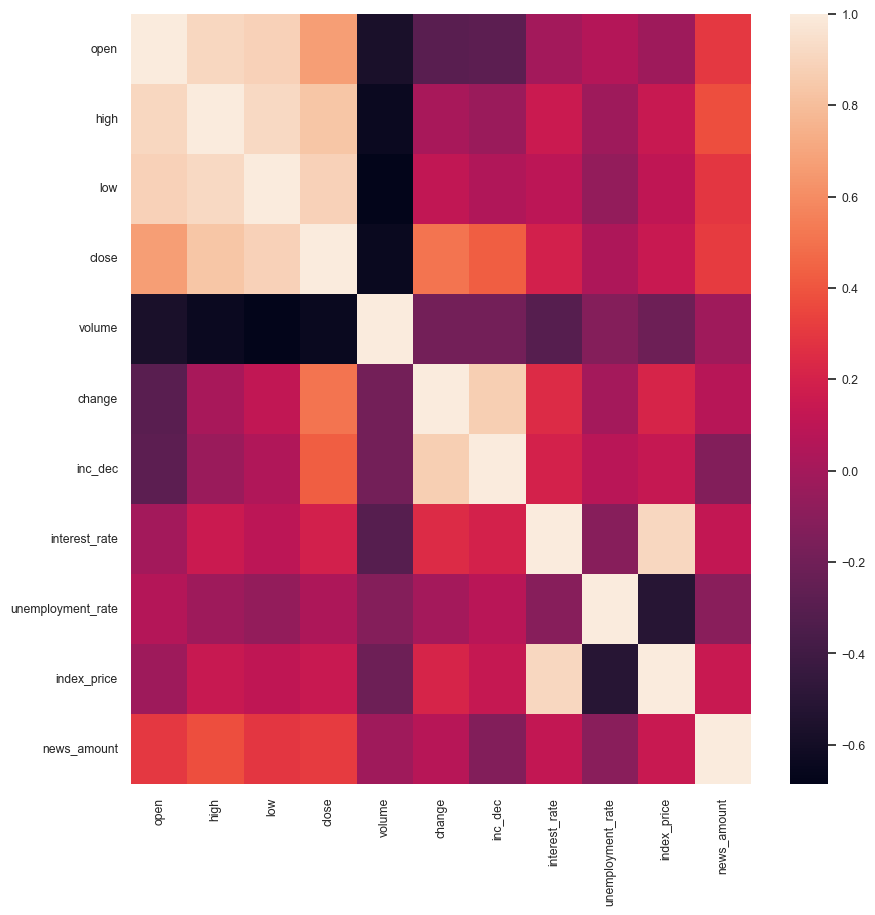

In [16]:
# 상관 관계 행렬 : 히트맵으로 확인
# 상관 계수를 이용해서 히트맵으로 표현 
corr_df = result_df.corr()

#히트맵
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(corr_df)
plt.show()

<Figure size 1600x800 with 0 Axes>

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

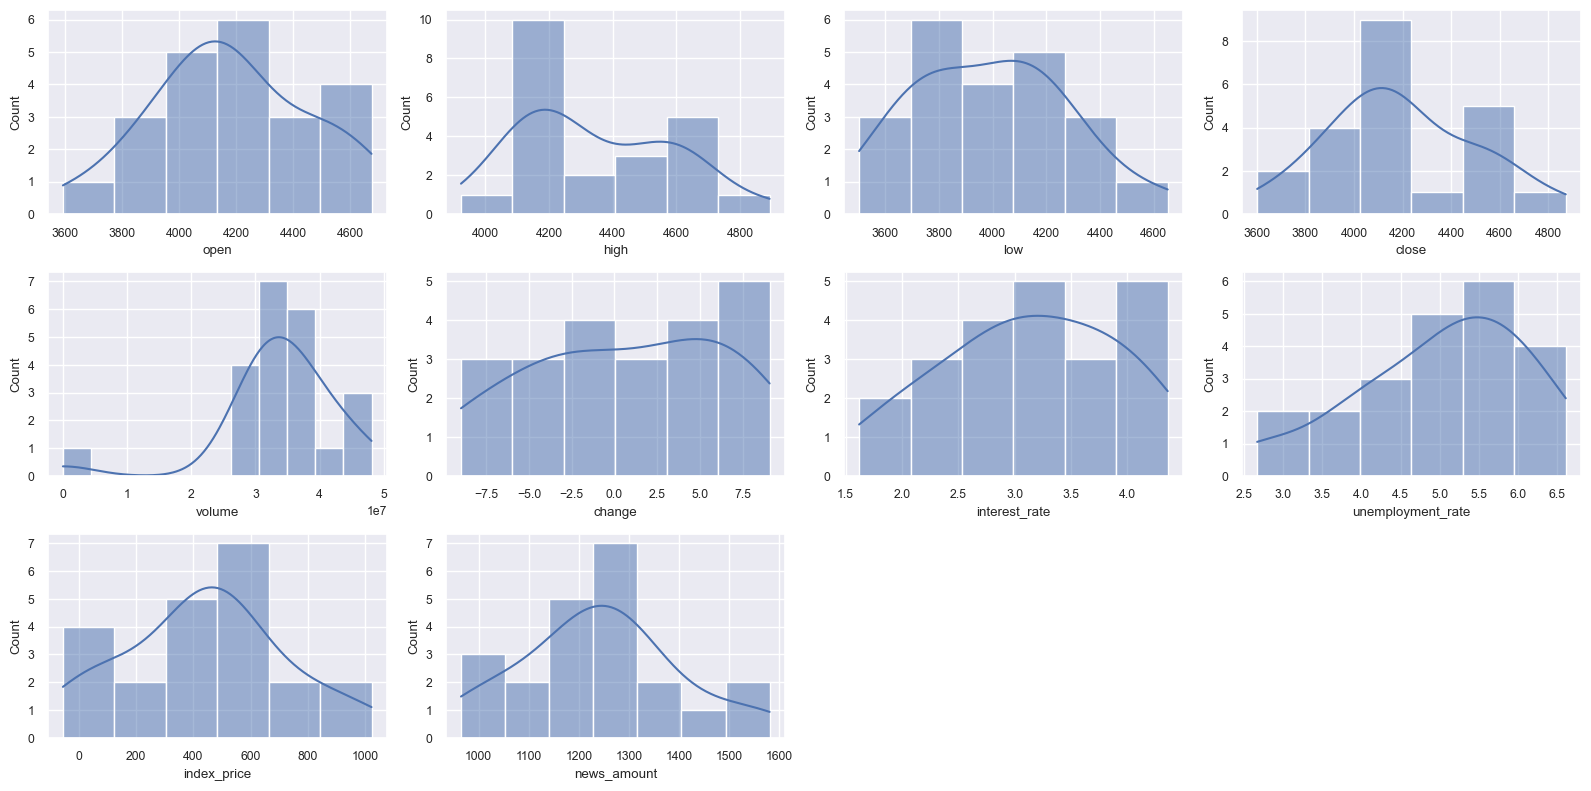

In [17]:
features = ['open', 'high', 'low', 'close', 'volume', 'change', 'interest_rate',
            'unemployment_rate', 'index_price', 'news_amount']

plt.figure(figsize=(16, 8))

# 히스토그램
for i, feature in enumerate(features):
    _=plt.subplot(3, 4, i + 1)
    _=sns.histplot(result_df[feature], kde=True)

plt.tight_layout()
plt.show()

In [19]:
labels = result_df['inc_dec']
features = result_df.drop('inc_dec', axis=1)

In [21]:
from sklearn.model_selection import train_test_split

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    # stratify=cancer.target,
                                                    random_state=156)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# (1) 개별 알고리즘 분류기 생성
# 로지스틱 회귀와 KNN 사용

# 로지스틱 알고리즘
lr_clf = LogisticRegression()

# knn 알고리즘
knn_clf = KNeighborsClassifier()

In [24]:
# 하이퍼파라미터
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # 정규화 강도
    'solver': ['liblinear', 'lbfgs', 'saga'],  # 최적화 알고리즘
    'max_iter': [100, 200, 300]  # 최대 반복 횟수
}

In [28]:
from sklearn.model_selection import GridSearchCV

grid_lr = GridSearchCV(lr_clf, param_grid_lr, scoring='accuracy', cv=5)
grid_lr.fit(X_train, y_train)

print(grid_lr.best_estimator_)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='accuracy')

LogisticRegression(C=0.01, solver='liblinear')


In [29]:
# 하이퍼파라미터
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # 이웃의 수
    'weights': ['uniform', 'distance'],  # 이웃의 가중치
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # 알고리즘
    'p': [1, 2]  # 거리 계산에 사용되는 파라미터
}

In [30]:
grid_knn = GridSearchCV(knn_clf, param_grid_knn, scoring='accuracy', cv=5)
grid_knn.fit(X_train, y_train)

print(grid_knn.best_estimator_)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

KNeighborsClassifier(p=1, weights='distance')


In [31]:
# bestparam값으로 다시 생성
# 로지스틱 알고리즘
lr_clf = LogisticRegression(C=0.01, solver='liblinear')

# knn 알고리즘
knn_clf = KNeighborsClassifier(p=1, weights='distance')

In [33]:
from sklearn.ensemble import VotingClassifier
# (2) 보팅 분류기 생성
# 소프트 보팅 
# estimators 2개: 리스트 형태로 각 분류기에 이름을 붙임
# lr_clf 분류기: LR / knn_clf 분류기: KNN
vo_clf = VotingClassifier(estimators =[('LR', lr_clf), ('KNN', knn_clf)],
                          voting='soft')
# 모델 = 분류기 = estimator

In [45]:
# VotingClassifier 학습/예측/평가

vo_clf.fit(X_train, y_train)
y_pred = vo_clf.predict(X_test)

print(f"Voting 분류기 정확도: {accuracy_score(y_test, y_pred):.4f}")

VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=0.01, solver='liblinear')),
                             ('KNN',
                              KNeighborsClassifier(p=1, weights='distance'))],
                 voting='soft')

Voting 분류기 정확도: 0.6000


In [44]:
# 로지스틱 회귀와 KNN 각 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    clf_name = clf.__class__.__name__
    print(f"{clf_name} 정확도 : {accuracy_score(y_test, y_pred):.4f}")

LogisticRegression(C=0.01, solver='liblinear')

LogisticRegression 정확도 : 0.6000


KNeighborsClassifier(p=1, weights='distance')

KNeighborsClassifier 정확도 : 0.2000


In [46]:
# 여러가지 평가지표 확인
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score,f1_score

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('오차행렬 :', cm)
print(f'정확도 : {accuracy}, 정밀도 : {precision}, 재현율 : {recall}, F1 Score : {f1}')

오차행렬 : [[1 0]
 [2 2]]
정확도 : 0.6, 정밀도 : 1.0, 재현율 : 0.5, F1 Score : 0.6666666666666666


In [43]:
pred_proba_1 = vo_clf.predict_proba(X_test)[:, 1]
roc_auc_1 = roc_auc_score(y_test, pred_proba_1)

pred_proba_0 = vo_clf.predict_proba(X_test)[:, 0]
roc_auc_0 = roc_auc_score(y_test, pred_proba_0)

print(f'ROC_AUC 1 : {roc_auc_1}, ROC_AUC 0 : {roc_auc_0}')

ROC_AUC 1 : 0.75, ROC_AUC 0 : 0.25


#### 결론
- KNN은 정확도가 매우 낮게 나옴
- 로지스틱 회귀는 비교적 정확도가 높게 나옴
- 그리고 정밀도도 높게 나옴 -> 상승은 상승이라고 전부 예측한 것
- 하지만 주식하락(0) 대한 ROC_AUC가 너무 낮게 나와서 돈을 잃을 가능성이 다수